# Integrating social capital metrics into director career data

Welcome to the next phase of our exploration into how social networks impact movie directors' careers!

**What are we aiming to do?**

Previously, we calculated the annual brokerage scores indicating social influence of every creative professional in the film industry from 2003 to 2023 (see `Phase_3_Constructing_Filmmaker_Network.ipynb`). We also created a time series dataset tracing each year in a director's career from their debut to 2023, along with a cross-sectional dataset that summarizes the outcomes of each director's first decade in the industry (see `Phase_2_Building_Time_Series_Data.ipynb`). 

Now, we turn our attention to:

1. Mapping brokerage scores to collaborators

We will identify the collaborators of movie directors and the exact times of their collaboration. This allows us to find the brokerage scores of the collaborators from our industry-wide dataset containing the scores of every creative professional. From there, we can examine how the social capital of collaborators at the time of their collaboration with a director affects the firector's career in the future.

We will also incorporate each director's own brokerage scores year by year into our dataset. This enables us to examine the influence of a director's own social capital on their career and adjust for its effects when assessing the impact of their collaborators' social capital.

2. Calculating collaborators' brokerage potential with reverse metrics

While effective size directly reflects a person's brokerage potential, other metrics do not. To address this, we implement reverse scoring:
- Reverse constraint: calculated as 1 + epsilon (a tiny constant) − constraint. This reflects that those with low constraint have high brokerage capacity. The inclusion of epsilon ensures that those with high constraints (1 and above) still receive a minimal yet non-zero score.
- Reverse local clustering: Similarly, this score is calculated as 1 + epsilon − local clustering. This reflects that those with low local clustering have high brokerage capacity.

3. Computing brokerage social capital across collaborators

With individual scores ready, we will compute both the average and maximum collaborator brokerage values for each director, each year. This gives us the average and peak brokerage social capital among the collaborators a director worked with at each point in their career.

**Looking ahead**

By the end of this notebook, we will have a dynamic dataset that not only tracks each director's career trajectory but also integrates critical metrics reflecting their own social capital and that of their connections. This will allow us to explore how networks contribute to career longevity and success in the film industry.

In [1]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import numpy as np # numerical operations
import os  # interacting with the operating system, such as changing directories
import pickle  # loading serialized data
import random # generating random numbers
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# 1. Identifying collaborators of movie directors

Our first task is to link each director to their collaborators based on the movies they worked on.

We'll use two datasets:
- `directors_cross_sectional`: This dataset, created in `Phase_2_Building_Time_Series_Data.ipynb`, includes a list of directors in our sample, along with their debut years and career outcomes.
- `movies_collaborations_2000_2023`: This dataset, created in `Phase_3_Constructing_Filmmaker_Network.ipynb`, lists all creative personnel involved in movies released between 2000 and 2023.

First, let's load these datasets and take a quick look at their structure to understand what information they contain.

In [2]:
# Load data on directors' career
directors_cross_sectional = pd.read_csv('directors_cross_sectional.csv')
# Load data on all collaborations among creative workers for movies released between 2000 and 2023.
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

In [3]:
# Display the first few rows of each dataset to understand their structure
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0


In the `directors_cross_sectional` dataset, each row represents a director in the sample, with information on director ID and debut year, as well as career outcomes variables like the time it takes for them to make a second movie.

In [4]:
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


The `movies_collaborations_2000_2023` dataset contains information on anyone who has ever worked on a movie in a creative role, with each row representing a movie-person (`tconst`-`nconst`) pair. 

Next, we will create a dataset called `directors_network`, where each row represents a director-collaborator-year combination. This dataset will include:
- Movie ID (`tconst`): Unique identifier for each film.
- Movie Release Year (`startYear`): Indicates when the movie was released.
- Director's ID (`nconst_director`): Unique identifier for the director.
- Director's Debut Year (`firstYear`): Marks the year each director made their debut.
- Collaborator's ID (`nconst`): Unique identifier for each collaborator.

We'll merge the `directors_cross_sectional` and `movies_collaborations_2000_2023` datasets to create this network. It's important to note that this data will contain info on the people these directors worked with when they were in any creative role, not just the director role. 

In [5]:
# Merging the directors' network dataset with the collaboration dataset on the 'nconst' column to link directors with movies they worked on. 
directors_network = pd.merge(directors_cross_sectional[['nconst_director', 'debut_year']], 
                             movies_collaborations_2000_2023.drop(columns=['category']), 
                             left_on='nconst_director', right_on='nconst', how='left').drop(columns='nconst')

# Merging the directors' network dataset with the collaboration dataset on the 'tconst' column to link directors with other creative personnel involved in the same movies. 
directors_network = pd.merge(directors_network, 
                             movies_collaborations_2000_2023.drop(columns=['category']), 
                             on=['tconst','startYear'], how='inner').rename(columns={"nconst": "nconst_collaborator"})

# Filtering out entries containing the directors ID in the collaborator column
directors_network = directors_network[directors_network['nconst_director'] != directors_network['nconst_collaborator']]

In [6]:
# Display the first few rows of the network dataset 
directors_network.head()

,nconst_director,debut_year,tconst,startYear,nconst_collaborator
0,nm1131265,2004,tt0108549,2004.0,nm0168948
2,nm1131265,2004,tt0108549,2004.0,nm1130611
3,nm1131265,2004,tt0108549,2004.0,nm0111876
4,nm1131265,2004,tt0108549,2004.0,nm2382648
5,nm1131265,2004,tt0108549,2004.0,nm0828024


Next, we need to identify the recent collaborators for each year in a director's career. This involves merging `directors_network` with the `directors_years` dataset created in `Phase_2_Building_Time_Series_Data.ipynb`, which traces each year of a director's career from their debut to 2023. The result is a dataset called `collaborators_by_year`, which has the following columns: 
- Director's ID (`nconst_director`): Unique identifier for the director.
- Current year (`year`): The current year under analysis.
- Collaborators List (`nconst`): Lists all creative professionals the director has collaborated with three years before the current year.

In [7]:
# load yearly data of directors
directors_years = pd.read_csv('directors_years.csv')

# Display the first few rows of the dataset to understand their structure
directors_years.head()

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004


In [8]:
# Converting director and collaborator IDs to categorical data types for efficient memory use
directors_network[['nconst_director', 'nconst_collaborator']] = directors_network[['nconst_director', 'nconst_collaborator']].astype('category')
directors_years.loc[:, 'nconst_director'] = directors_years['nconst_director'].astype('category')

# Merging the yearly data of directors with their network data based on director IDs
directors_years_network = pd.merge(directors_years, 
                                   directors_network.drop_duplicates(subset=['tconst', 'nconst_director', 'nconst_collaborator']), 
                                   on=['nconst_director', 'debut_year'], how='left')

# Calculating the time frame (the preceding three years) to identify collaborators 
directors_years_network['year_min'] = directors_years_network['year'] - 3
directors_years_network['year_max'] = directors_years_network['year'] - 1

# Filtering to include only collaborations within the specified time frame
directors_years_network = directors_years_network[(directors_years_network['startYear'] >= directors_years_network['year_min']) & (directors_years_network['startYear'] <= directors_years_network['year_max'])]

In [10]:
# Display the first few rows of the data linking the directors to recent collaborators
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.0,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.0,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.0,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.0,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.0,nm0828024,2002,2004


Now we transform the `directors_years_network` dataset, where each row represents a link between a director and one of their collaborator, into a more compact format called `collaborators_by_year`. This new dataset will have each row representing a director-year pair, including a list of all collaborators from the previous three years.

In [11]:
# Grouping the data by director and year, then compiling a list of unique collaborators for each director-year pair.
collaborators_by_year = directors_years_network.groupby(['nconst_director', 'year'])['nconst_collaborator'].apply(lambda x: list(set(x.dropna()))).reset_index()

# Display the first few rows of the result
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, n..."
3,nm0000083,2011,"[nm0613273, nm1677271, nm0662263, nm1730786]"
4,nm0000083,2012,"[nm0613273, nm1677271, nm0662263, nm1730786]"


In [13]:
# Add information on directors' debut year
collaborators_by_year = collaborators_by_year.merge(directors_cross_sectional[['nconst_director', 'debut_year']], how='left')

With the `collaborators_by_year` dataset, we can efficiently apply functions to each director-year pair to map pre-calculated brokerage scores to the collaborators.

Before diving into these complex analyses, let’s first understand how many directors had collaborator information at their debut. This detail is crucial as it indicates their prior involvement in the film industry in other roles before becoming directors.

Given our dataset's lagged structure, a director's social capital in any given year is based on their collaboration ties from the previous three years. Consequently, directors who had not worked on movies in the three years leading up to their debut won't have any collaborator information for their debut year.

In [17]:
# Check the number of directors with collaborator info at their debut year
len(collaborators_by_year[collaborators_by_year['year'] == collaborators_by_year['debut_year']])

4051

From our previous analysis in `Phase_1_Tracking_Movie_Directors_Career.ipynb`, we discovered that about 16% of directors in our sample had worked in other creative roles before directing their first movie. Now, we find that among these, 4,051 directors (6% of the entire sample) had done so three years before their directorial debut.

# 2. Calculating collaborators' degree centrality

In our previous phase, `Phase_3_Constructing_Filmmaker_Network.ipynb`, we calculated annual brokerage scores (constraint, effective size, and local clustering) for every creative worker in the film industry from 2003 to 2023. I had originally intended to compute degree centrality in that phase but forgot. But that's ok, we can do it now. 

Degree centrality measures the number of direct connections a person has, indicating their network breadth and connectivity within the industry. This metric provides a straightforward yet powerful insight into an individual's social capital. Unlike brokerage scores, degree centrality can be calculated more efficiently without constructing large-scale network graphs, which takes a lot of time given our dataset involving hundreds of thousands of people and billions of potential connections.

We'll use two datasets to calculate collaborators' degree centrality:
- `directors_years_network`: This dataset created above links directors to their collaborators at the time of collaboration.
- `movies_collaborations_2000_2023`: This dataset, created in `Phase_3_Constructing_Filmmaker_Network.ipynb`, links movies released between 2000 and 2023 to the creative professionals involved in their production.

First, let's display the first few rows of our datasets to understand their structure and contents:

In [20]:
# Display the first few rows of the dataset to understand its structure and contents.
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


Each row in this dataset represents a movie-person (`tconst`-`nconst`) pair, along with details about their role and the movie's release year.

In [21]:
# Display the first few rows of the 'merged_data' dataset to understand its structure and contents.
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.0,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.0,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.0,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.0,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.0,nm0828024,2002,2004


Here, each row represents a director-collaborator-year (`nconst_director`-`nconst`-`year`) combination, along with additional information such as the movie they collaborated on, the year of release, and the director's debut year.

With the `movies_collaborations_2000_2023` data and `merged_data` ready, we can proceed to calculate the collaborators' degree centrality at the time of their collaboration with the director.

First, we extract unique combinations of collaborators and the years of their collaborations with the director.

In [22]:
# Extract unique pairs of collaborators and years from the merged dataset to avoid duplication in analysis.
unique_collaborator_years = directors_years_network[['nconst_collaborator', 'year']].drop_duplicates().reset_index(drop=True)

# Display the first few rows of the data to understand the structure.
unique_collaborator_years.head()

,nconst_collaborator,year
0,nm0168948,2005
1,nm1130611,2005
2,nm0111876,2005
3,nm2382648,2005
4,nm0828024,2005


Next, we define a function, `calculate_degree_centrality`, which:
- Identifies the films each collaborator worked on within the three years leading up to the current analysis year.
- Counts the number of unique collaborators involved in these films, excluding the focal collaborator. This gives us a measure of each collaborator's network centrality at the time of their collaboration with the director.

In [ ]:
# Define a function to calculate the degree centrality for each collaborator in each director-year pair.
# Degree centrality measures how many direct connections (collaborators) each individual has, indicating their network influence.
def calculate_degree_centrality(unique_collaborator_years, movies_collaborations_df):
    degree_centrality_list = [] # Initialize an empty list to collect degree centrality results

    # Iterate over each row in the merged data to calculate degree centrality for each collaborator
    for _, row in unique_collaborator_years.iterrows():
        year = row['year']
        nconst_collaborator = row['nconst']
        year_min = year - 3 # Set the start of the timeframe to three years prior.

        # Identify movies the collaborator has worked on within the timeframe
        relevant_movies = movies_collaborations_df[
            (movies_collaborations_df['nconst'] == nconst_collaborator) &
            (movies_collaborations_df['startYear'] >= year_min) &
            (movies_collaborations_df['startYear'] < year)
        ]['tconst'].unique()

        # Fetch all collaborators for those movies, excluding the current collaborator
        all_collaborators_for_movies = movies_collaborations_df[
            (movies_collaborations_df['tconst'].isin(relevant_movies)) &
            (movies_collaborations_df['nconst'] != nconst_collaborator)
        ]['nconst'].unique()

        # Calculate the degree centrality as the count of unique collaborators
        degree_centrality = len(all_collaborators_for_movies)

        # Append results to the list
        degree_centrality_list.append({
            'year': year,
            'nconst_collaborator': nconst_collaborator,
            'degree_centrality': degree_centrality
        })

    # Convert the list to a DataFrame for further analysis
    return pd.DataFrame(degree_centrality_list)

# Calculate degree centrality for collaborators
collaborator_degree_centrality = calculate_degree_centrality(unique_collaborator_years, movies_collaborations_2000_2023)

# Save the degree centrality results in a CSV file for future reference.
collaborator_degree_centrality.to_csv('collaborator_degree_centrality.csv', index=False)

In [23]:
# Display the first few rows of the calculated degree centrality data to understand its structure.
collaborator_degree_centrality.head()

,year,nconst_collaborator,degree_centrality
0,2004,nm0168948,3
1,2004,nm1130611,0
2,2004,nm0111876,0
3,2004,nm2382648,0
4,2004,nm0828024,0


Finally, we convert this dataframe into a dictionary for efficient access in subsequent analyses.

In [24]:
# Convert degree centrality results to a dictionary for quick lookup during scoring.
collaborator_degree_centrality = collaborator_degree_centrality.set_index(['nconst_collaborator', 'year'])['degree_centrality'].to_dict()

In [26]:
with open('collaborator_degree_centrality.pkl', 'wb') as f:
        pickle.dump(collaborator_degree_centrality, f)

# 3. Mapping social capital scores to collaborators

With collaborators' degree centrality and brokerage scores ready, we can now add them to our primary dataset. For this, we define and apply a function to retrieve each collaborator's brokerage and degree centrality scores from the dictionaries holding the scores for everyone in the industry, based on their ID and the specific year these scores were calculated. This gives us the social capital metrics of the collaborators at the time of their collaboration with the director.

## 3.1. Understanding the dictionary holding social capital scores

First, let's load the `brokerage_scores_by_year.pkl` file, which houses the calculated brokerage scores for every creative worker in the film industry from 2003 to 2023, to understand its structure. From then, we can come up with ideas on how to extract collaborators' brokerage scores from it.

In [27]:
# Loading brokerage social capital metrics from a serialized file.
# This data includes brokerage scores for every filmmaker in the network by year, providing insight into their network influence.
brokerage_scores_by_year = pd.read_pickle('brokerage_scores_by_year.pkl')

In [28]:
# Print the dictionary keys, which are the years for which data is available.
# This is to ensure the data covers the expected timeframe.
print("Years in the dataset:", list(brokerage_scores_by_year.keys()))

Years in the dataset: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [29]:
# Check the structure of a nested dictionary by picking a sample year
sample_year = next(iter(brokerage_scores_by_year))  # Get the first year in the dictionary
# Print the keys of the nested dictionary for the first year in the data, which are the types of brokerage scores available.
print(f"Brokerage score types available in {sample_year}:", list(brokerage_scores_by_year[sample_year].keys()))

Brokerage score types available in 2003: ['constraint', 'effective_size', 'local_clustering']


In [30]:
# Pick one type of score to sample, for example 'constraint'
score_type = 'constraint'
# Sample 10 random IDs within the 'constraint' scores
sample_ids = random.sample(list(brokerage_scores_by_year[sample_year][score_type].keys()), 10)
# Print the constraint scores for the randomly selected people
print(f"Random sample of {score_type} scores for {sample_year}:")
for nconst in sample_ids:
        print(f"ID {nconst}: {brokerage_scores_by_year[sample_year][score_type][nconst]}")

Random sample of constraint scores for 2003:
ID nm0411654: 0.169909408226668
ID nm1384768: 0.6480000000000001
ID nm2013346: 0.765625
ID nm9672018: 0.925925925925926
ID nm1164606: 0.42653155555555566
ID nm0533301: 0.5336859504132233
ID nm0885537: 0.14138705575575372
ID nm0831578: 0.6033347800925927
ID nm0459508: 0.5681382716049383
ID nm1420055: 0.6865234375


So, our data is organized in a multi-layered dictionary format, where:
- The top layer corresponds to each year.
- The second layer categorizes data into the types of brokerage scores.
- The deepest layer maps individual IDs to their respective scores.

This structure allows us to efficiently retrieve any individual’s brokerage score for a specific year and score type. Think of this dictionary as a set of filing cabinets, where each cabinet is dedicated to a specific year. Inside each cabinet, there are several folders, each labeled according to the type of brokerage scores it contains—such as "constraint," "effective size," or "local clustering." Each folder is filled with individual files; each file pertains to a specific person. The information in the file is the person's score for that specific type of brokerage during that year. If we want to find out a person’s score for a certain type of brokerage metric in a given year, we would first choose the correct year's cabinet, select the folder for the score type we are interested in, and then find the file labeled with the person’s ID.

## 3.2. Mapping social capital scores to collaborators

Now, we match the pre-calculated brokerage scores and the newly computed degree centrality scores to each person and year in the `collaborators_by_year` data. For this, we'll define a function `map_all_brokerage_scores` to get the scores for each collaborator at the time of their collaboration with the director. 

The updated `collaborators_by_year` dataframe will include the following columns: 
- `nconst_director`: A unique identifier for each director.
- `year`: The specific year being considered for the director's career.
- `nconst`: A list of unique identifiers for collaborators who worked with the director in that year.
- `brokerage_scores`: A new column added through the application of the `map_all_brokerage_scores` function. This column contains a list of dictionaries, where each dictionary corresponds to a collaborator and contains the following network metrics:
    - `constraint`: The collaborator's constraint score for the specified year.
    - `effective_size`: The collaborator's effective size score for the specified year.
    - `local_clustering`: The collaborator's local clustering coefficient for the specified year.
    - `degree_centrality`: The collaborator's degree centrality for the specified year.

In [33]:
# Defining a function to map brokerage scores (constraint, effective size, and local clustering) and degree centrality 
# to each collaborator for a given year
def map_all_brokerage_scores(row):
    year = row['year']  # The year under consideration
    collaborators = row['nconst_collaborator']  # List of collaborator IDs for the director in that year
    brokerage_scores = []  # Initialize a list to hold the brokerage scores for each collaborator
    
    # Iterate through each collaborator's ID
    for nconst in collaborators:
        # Extract brokerage scores
        constraint_score = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(nconst, None)
        effective_size_score = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(nconst, None)
        local_clustering_score = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(nconst, None)
        
        # Fetch degree centrality score from the dictionary
        degree_centrality_score = collaborator_degree_centrality.get((nconst, year), None)
        
        # Append the retrieved scores to a list
        brokerage_scores.append({
            nconst: {
                'constraint': constraint_score,
                'effective_size': effective_size_score,
                'local_clustering': local_clustering_score,
                'degree_centrality': degree_centrality_score 
            }
        })
    
    return brokerage_scores

# Apply the function to each row in the dataset to associate each director-year pair with their collaborators' brokerage scores.
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(map_all_brokerage_scores, axis=1)

In [34]:
# Set display options to show entire text of brokerage scores in the DataFrame output for better verification
pd.set_option('display.max_colwidth', None)

# Display the first few rows of the DataFrame after mapping brokerage scores to verify correct mapping
collaborators_by_year.head(10)

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19}}]"
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14}}]"
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7}}, {'nm0690875': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0917916': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm1677271': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7}}, {'nm1730786': {'constraint': 0.5006975446428571, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0653114': {'constraint': 0.3462925170068027, 'effective_size': 4.75, 'local_clustering': 0.4642857142857143, 'degree_centrality': 8}}, {'nm0662263': {'constraint': 0.3168048469387755, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}]"
3,nm0000083,2011,"[nm0613273, nm1677271, nm0662263, nm1730786]",2007,"[{'nm0613273': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm1677271': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0662263': {'constraint': 0.3657724808673469, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}, {'nm1730786': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}]"
4,nm0000083,2012,"[nm0613273, nm1677271, nm0662263, nm1730786]",2007,"[{'nm0613273': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm1677271': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}, {'nm0662263': {'constraint': 0.3828125, 'effective_size': 5.0, 'local_clustering': 0.42857142857142855, 'degree_centrality': 8}}, {'nm1730786': {'constraint': 0.6865234375, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 4}}]"
5,nm0000083,2018,"[nm4895344, nm4896032]",2007,"[{'nm4895344': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}, {'nm4896032': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}

Looks great! 

# 4. Understanding collaborators' social capital metrics 

Now that we have the social capital scores of the collaborators, let's analyze them to understand their distribution and characteristics. We begin with a broad overview, generating descriptive statistics and correlations for the metrics. This step provides insights into their distribution and identifies key characteristics and relationships within our data.

Then we focus our analysis on extreme cases:
- High constraint: We explore cases where collaborators have a constraint score greater than 1 and exactly 1 to understand those who might be highly constrained by their connections.
- High Clustering: We investigate collaborators with a local clustering score of 0 to shed light on individuals within highly cohesive networks.
- No Clustering: Conversely, analyzing cases with zero local clustering helps identify those with completely unconnected network connections.

## 4.1. Converting dictionaries to dataframes

Before diving into the analysis, let's convert the `brokerage_scores` column from the `collaborators_by_year` DataFrame into a more accessible format. Currently, each collaborator's scores are stored within nested dictionaries, making direct analysis challenging. To address this, we extract each collaborator's unique identifier and their scores (constraint, effective size, local clustering, and degree centrality) from these dictionaries, placing them into distinct rows in a DataFrame for easier analysis.

In [35]:
# Initialize an empty list to collect data for creating a new DataFrame dedicated to collaborators' scores
collaborator_brokerage = []

# Loop through each row in the collaborators_by_year DataFrame to extract individual brokerage scores
for _, row in collaborators_by_year.iterrows():
    # Each 'brokerage_scores' contains multiple dictionaries, one for each collaborator
    for score_dict in row['brokerage_scores']:
        # Extract each collaborator's ID and their respective scores
        for nconst, scores in score_dict.items():
            # Append each collaborator's scores to the list as a dictionary
            collaborator_brokerage.append({
                'collaborator_id': nconst,
                'constraint': scores.get('constraint'),
                'effective_size': scores.get('effective_size'),
                'local_clustering': scores.get('local_clustering'),
                'degree_centrality': scores.get('degree_centrality'),
            })

# Convert the list of score dictionaries into a DataFrame for easier analysis
collaborator_brokerage = pd.DataFrame(collaborator_brokerage)

# Display the first few rows of the new DataFrame to understand its structure
collaborator_brokerage.head()

,collaborator_id,constraint,effective_size,local_clustering,degree_centrality
0,nm0613273,0.514127,1.000000,1.000000,5
1,nm0690875,0.303648,6.000000,0.444444,10
2,nm0917916,0.514127,1.000000,1.000000,5
3,nm1677271,0.514127,1.000000,1.000000,5
4,nm0653114,0.125969,15.210526,0.210526,19


## 4.2. Descriptive statistics

Let's generate some descriptive statistics to understand the distribution of social capital metrics across collaborators. We'll also create density plots, which provide a smooth curve representing the distribution. This is particularly useful for understanding the general patterns and variations across the sample.

In [38]:
# Setting display format for floating point numbers to ensure consistent formatting in output
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display descriptive statistics for all collaborators to understand overall distribution of scores
collaborator_brokerage.describe()

,constraint,effective_size,local_clustering,degree_centrality
count,1542919.00,1542919.00,1542919.00,1542919.00
mean,0.48,4.99,0.74,8.62
std,0.26,11.03,0.34,11.35
min,0.01,1.00,0.00,1.00
25%,0.27,1.00,0.44,4.00
50%,0.48,1.00,1.00,5.00
75%,0.65,5.75,1.00,10.00
max,1.12,396.02,1.00,399.00


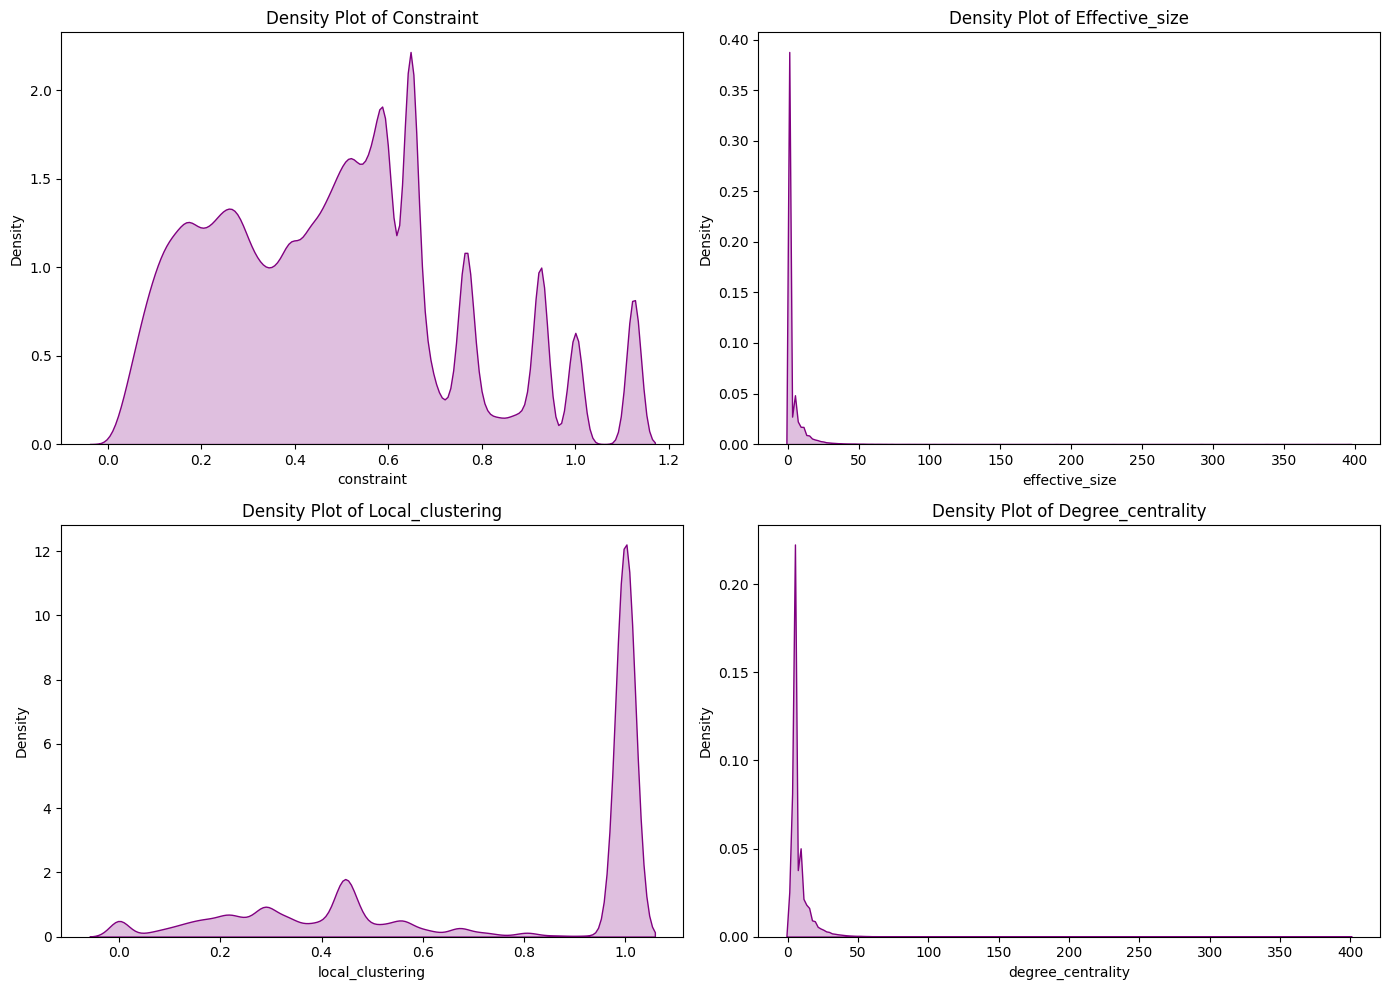

In [39]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

metrics = ['constraint', 'effective_size', 'local_clustering', 'degree_centrality']

# Loop through the metrics and create a subplot for each
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(collaborator_brokerage[metric], fill=True, color='purple')
    plt.title(f'Density Plot of {metric.capitalize()}')
    plt.xlabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()

**Constraint:**
- Both the mean and median values being around 0.50 suggest a moderate level of constraint, meaning that collaborators typically experience a balanced level of dependency within their networks.
- Theoretically, constraint values should range from 0 to 1. Observing values slightly above 1 suggests instances of very high dependency on specific connections. We'll explore these cases later to understand their network dynamics.
- The relatively low standard deviation (0.26) indicates that most collaborators' constraint scores cluster around the mean, suggesting uniformity in network constraints among most individuals.

**Effective Size**
- The average effective size of about five suggests that collaborators can typically access new information from approximately five contacts.
- The median significantly lower than the mean points to a right-skewed distribution, influenced by a few collaborators with exceptionally expansive networks (probably those who worked on big budget movies with hundreds of creative proffessionals invovled).

**Local Clustering:**
- High mean (0.74) and median values (1.00) highlight that many collaborators are part of highly interconnected groups. 
- A median of 1 indicates that for half of the data, every possible tie within a collaborator's neighborhood is realized.

**Degree Centrality:**
- The average score suggests that collaborators are typically connected directly to about 8 other individuals.
- The wide rangenge (0.00 to 399) means that a small number of collaborators have extremely high centrality, indicating they are highly influential or central within the network.

## 4.3. Correlation analyses

Next, we explore how different network metrics—constraint, effective size, local clustering, and degree centrality—are related within our dataset. For this, we generate a correlation matrix create and create a heatmap that displays the correlations among the network brokerage scores:

In [40]:
# Compute the correlation matrix
correlation_matrix = collaborator_brokerage[['constraint', 'effective_size', 'local_clustering', 'degree_centrality']].corr()

correlation_matrix

,constraint,effective_size,local_clustering,degree_centrality
constraint,1.00,-0.48,0.61,-0.54
effective_size,-0.48,1.00,-0.55,0.99
local_clustering,0.61,-0.55,1.00,-0.53
degree_centrality,-0.54,0.99,-0.53,1.00


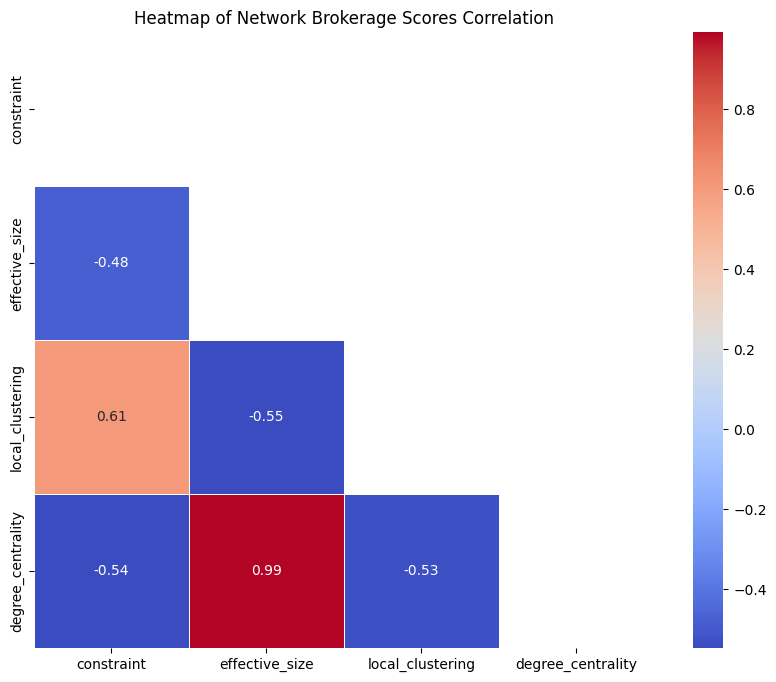

In [41]:
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(10, 8))  # Set the figure size
# Draw the heatmap with the mask
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)
plt.title('Heatmap of Network Brokerage Scores Correlation')
plt.show()

- Constraint and Effective Size (-0.48): This moderate negative correlation means that as the constraint of a person increases (meaning their dependency on a few connections is higher), their effective size (number of useful, non-redundant contacts) tends to decrease. High constraint often indicates that a few connections are overly dominant, which naturally limits the number of useful, independent connections.
- Constraint and Local Clustering (0.61): This a positive correlation means that higher constraint levels often occur together with higher local clustering. This makes sense because when a collaborator’s network neighbors are highly interconnected (high local clustering), it can lead to a higher dependency on these neighbors (higher constraint).
- Constraint and Degree Centrality (-0.54): This negative correlation aligns with the notion that if a person is highly dependent on a few connections (high constraint), they are less likely to have a broad range of direct connections (low degree centrality).
- Effective Size and Local Clustering (-0.55): The negative correlation indicates that higher effective sizes (more unique and useful contacts) tend to correspond with lower levels of local clustering. This makes sense since a more extensive network with more unique connections generally leads to fewer tightly-knit clusters.
- Effective Size and Degree Centrality (0.99): This is a high positive correlation, which is expected, as having a higher number of unique, non-redundant contacts (effective size) typically means a person also has a higher total number of direct connections (degree centrality).
- Local Clustering and Degree Centrality (-0.53): This moderate negative correlation implies that when a collaborator’s immediate network is tightly interconnected, they often do not have many connections in general (low degree of centrality).

These correlations reflect a natural trade-off between network diversity (effective size and degree centrality) and cohesion (local clustering and constraint). Networks that are very cohesive often lack diversity, and vice versa.

## 4.4. Understanding extreme cases

Now, let's focus on specific groups of people with low brokerage potential: people with high constraint scores (both =1 and >1) and people with a local clustering of 1. 

### Constraint Scores Above 1

Constraint scores typically range from 0 to 1, where a score closer to 1 indicates a high level of dependency on interconnected network ties. Scores exceeding 1, though unusual, are possible due to specific way constraint is calculated (see [NetworkX's documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.structuralholes.constraint.html)). This phenomenon often occurs in tightly-knit networks or cliques where a node has multiple redundant connections to other nodes that are also heavily interconnected.

To better understand the specific characteristics of nodes with constraint scores above 1, let's perform descriptive statistics analyses on the other network metrics (effective size, local clustering, degree centrality) of these people.

In [42]:
# Describe the distribution of scores for collaborators with a constraint score greater than 1, indicating over-constrained positions
collaborator_brokerage[collaborator_brokerage['constraint'] > 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,50546.00,50546.00,50546.00,50546.00
mean,1.12,1.00,1.00,2.00
std,0.02,0.00,0.00,0.00
min,1.01,1.00,1.00,2.00
25%,1.12,1.00,1.00,2.00
50%,1.12,1.00,1.00,2.00
75%,1.12,1.00,1.00,2.00
max,1.12,1.00,1.00,2.00


For collaborators with a constraint score larger than 1, there is no variability in other network metrics, meaning these people have very similar network configuration:
- Effective Size (1.00) indicates that these collaborators are interacting within a very narrow circle, likely just one other node providing new information.
- Local Clustering (1.00) indicates a fully interconnected network where each contact is directly connected to every other.
- Degree Centrality (2.00) suggests that they each connect directly to only two others.

The combination of high constraint, an effective size of one, complete local clustering, and a minimal degree centrality paints a picture of a network that is highly insular.

### Constraint Scores of 1

What about people with constraint scores of 1, what is the characteristics of their network? Again, let's generate descriptive statistics for these people to understand their network better.

In [43]:
# Describe the distribution of scores for collaborators with a constraint score exactly equal to 1, indicating a perfectly constrained position
collaborator_brokerage[collaborator_brokerage['constraint'] == 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,34793.00,34793.00,34793.00,34793.00
mean,1.00,1.00,0.00,1.00
std,0.00,0.00,0.00,0.00
min,1.00,1.00,0.00,1.00
25%,1.00,1.00,0.00,1.00
50%,1.00,1.00,0.00,1.00
75%,1.00,1.00,0.00,1.00
max,1.00,1.00,0.00,1.00


For collaborators with a constraint score of 1, the lack of variability in other network metrics means that they all have the same network structure:
- Effective Size (1.00): These individuals gain information exclusively from one source, suggesting the absence of network diversity.
- Degree Centrality (1.00): A degree centrality of 1 indicates that these collaborators have a singular direct connection, underscoring their isolated position within the broader network.
- Local Clustering (0.00): A local clustering coefficient of 0 here is intriguing because it typically indicates that a node's neighbors are not connected to each other—contrary to what one might expect given the high constraint. However, because the degree centrality is also 1, it indicates these nodes likely have only one connection, making the concept of neighbor interconnectivity (local clustering) non-applicable.

These collaborators who has a constraint score of 1 are fully dependent on a singular connectork. Thus, they are similar to people with constraint scores greater than 1 in that both groups are in highly constrained environments with very limited capacity for brokerage. However, the difference is that while those with constraint scores greater than 1 often reside in densely interconnected groups or cliques, individuals with a constraint score of 1 are uniquely isolated with only one connection. This results in no local clustering compared to the complete interconnectivity (local clustering of 1) observed in the former group.

### Local Clustering Scores of 1

Another group with limited capacity for brokerage is those with local clustering scores of 1, indicating that the immediate network neighbors of these people are all directly connected to each other, forming a completely interconnected group.

Let's generate descriptive statistics for these grouple to understand their network better.

In [44]:
# Describe scores for collaborators with a local clustering score of 1, indicating fully clustered network positions
collaborator_brokerage[collaborator_brokerage['local_clustering'] == 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,920760.00,920760.00,920760.00,920760.00
mean,0.62,1.00,1.00,4.52
std,0.19,0.00,0.00,1.33
min,0.20,1.00,1.00,2.00
25%,0.49,1.00,1.00,4.00
50%,0.59,1.00,1.00,5.00
75%,0.69,1.00,1.00,5.00
max,1.12,1.00,1.00,9.00


Across all individuals in this subset, the effective size remains consistently at one. This indicates that despite having multiple contacts, only one provides new information, indicating a closed network that does not facilitate informational diversity.

An average constraint score of 0.62 among these individuals indicates a moderate dependency on their network ties. While deeply embedded within their groups, some times these individuals' ties are not excessively restrictive, allowing some degree of external interaction.

It might initially seem counterintuitive that someone can exhibit a local clustering of 1, an effective size of 1, yet not be overly dependent on their immediate contacts (demonstrated by a lower constraint score). However, this can occur due to broader network connections. That is, if the contacts within a person’s immediate, fully connected group also maintain diverse connections outside this group, it reduces the person's overall dependence on them. Each contact's external ties provide alternative pathways for the focal person to access diverse information and resources, reducing the focal person's constraint. 

### Local Clustering Scores of 0

So far, we have focused on extreme cases of people embedded in closed networks with little brokerage potential. Now, we turn our attention to the other extreme-those whose immediate neighbors do not connect with each other at all, suggesting a network structure where each connection potentially offers unique, non-redundant information.

Let's see the network profiles of everyone with a local clustering of 0.

In [45]:
# Identify and display unique cases of collaborators with a local clustering score of 0, indicating no clustering in their local network
collaborator_brokerage[collaborator_brokerage['local_clustering'] == 0].drop(columns='collaborator_id').drop_duplicates()

,constraint,effective_size,local_clustering,degree_centrality
2119,1.00,1.00,0.00,1
2561,0.50,2.00,0.00,2
65188,0.33,3.00,0.00,3
346353,0.25,4.00,0.00,4
1204699,0.20,5.00,0.00,5
1230341,0.17,6.00,0.00,6


A highest constraint score (1) and lowest effective size and degree centrality (1) in this context likely indicates a collaborator with only one connection or very few, highly dependent connections. However, in other cases when local clustering is 0, we see that degree centrality and effective size is equal to each other, indicating all contacts are unconnected and thus are non-redundant contacts.

# 5. Calculating brokerage potential through reverse metrics

We now focus on deriving people's brokerage potential from the calculated scores. Among the three brokerage metrics we calculated:
- Effective Size directly signifies brokerage potential by measuring the number of non-redundant connections a node possesses. This metric illustrates the extent to which an individual can access unique resources and information through their direct ties.
- Constraint gauges a node's dependency on its neighbors. A higher constraint score indicates a stronger reliance on a limited number of connections, which may restrict the node's ability to function as an effective broker.
- Local Clustering evaluates the degree to which a node's neighbors are interconnected. A high local clustering score suggests that the node is embedded within a closely-knit group, potentially limiting its capacity to bridge diverse parts of the network.

What this means is that someone's potential to act as a broker is inversely related to their constraint and local clustering scores. Thus, to assess someone's brokerage potential, we employ reverse metrics:
- Reverse Constraint: We calculate this as 1 + $\epsilon$ - constraint, where $\epsilon$ is a very small number. This approach ensures that even nodes with extremely high constraint scores receive a minimal but non-zero brokerage score. Only those with 0 connection will receive a brokerage score of 0. Overall, this metric inversely reflects constraint, emphasizing nodes with lower scores as having higher potential for brokerage.
- Reverse Local Clustering: Similarly, this is calculated as 1 + $\epsilon$ - local clustering. This score highlights nodes with the potential to connect otherwise disparate groups, inversely proportional to their clustering score.

To do this, we first define and implement functions to calculate reverse metrics for both constraint and local clustering. These functions account for various scenarios, including missing scores or extreme values. 

In [46]:
epsilon = 1e-5  # Define a very small number

# define functions for calculating reverse scores 
def calculate_reverse_constraint(constraint, degree_centrality):
    if constraint is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    elif constraint > 1:
        return epsilon
    else:
        return 1 + epsilon - constraint

def calculate_reverse_local_clustering(local_clustering, degree_centrality):
    if local_clustering is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    else:
        return 1 + epsilon - local_clustering

# define function to recalculate constraint and local clustering and calculate their reverse scores
def apply_reverse_scores(row):
    updated_scores = []
    for score_dict in row['brokerage_scores']:
        for nconst, scores in score_dict.items():
            # Fetch original scores
            original_constraint = scores.get('constraint')
            original_local_clustering = scores.get('local_clustering')
            degree_centrality = scores.get('degree_centrality')

            # Initialize recalculated scores with original values or 0 if None
            recalculated_constraint = original_constraint if original_constraint is not None else 0
            recalculated_local_clustering = original_local_clustering if original_local_clustering is not None else 0

            # Apply conditions for recalculations
            if degree_centrality == 1:
                recalculated_constraint = epsilon
                recalculated_local_clustering = epsilon

            # Calculate reverse scores using the original values
            reverse_constraint = calculate_reverse_constraint(original_constraint, degree_centrality)
            reverse_local_clustering = calculate_reverse_local_clustering(original_local_clustering, degree_centrality)

            # Update the dictionary with original, recalculated, and reverse scores
            scores['recalculated_constraint'] = recalculated_constraint
            scores['recalculated_local_clustering'] = recalculated_local_clustering
            scores['reverse_constraint'] = reverse_constraint
            scores['reverse_local_clustering'] = reverse_local_clustering

            updated_scores.append({nconst: scores})
    return updated_scores

# Apply the function to update brokerage_scores with original, recalculated, and reverse scores
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(apply_reverse_scores, axis=1)

In [47]:
# Display the first few rows of the updated DataFrame with the new scores to verify successful computation
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}]"
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30614693877551025, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6938630612244898, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1654934959096975, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8345165040903025, 'reverse_local_clustering': 0.7142957142857144}}]"
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.7142857142857144, 'local_clustering': 0.7142857142857143, 'degree_centrality': 7, 'recalculated_constraint': 0.4229693356934609, 'recalculated_local_clustering': 0.7142857142857143, 'reverse_constraint': 0.5770406643065391, 'reverse_local_clustering': 0.28572428571428576}}, {'nm0690875': {'constraint': 0.513961224489796, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.

Now, we create another function to extract and compute both average and maximum values for each type of brokerage score for each director-year pair, thus quantifying the brokerage potential of each director's collaborators at the time of their collaboration.

In [48]:
def compute_stats(row):
    # Extract the list of brokerage scores dictionaries for the row
    brokerage_scores = row['brokerage_scores']
    
    # Initialize lists to hold each type of score for aggregation
    constraint_scores = []
    local_clustering_scores = []
    reverse_constraint_scores = []
    effective_size_scores = []
    reverse_local_clustering_scores = []
    degree_centrality_scores = []
    
    # Iterate through each brokerage scores dictionary, extracting the scores
    for score_dict in brokerage_scores:
        for scores in score_dict.values():
            if 'recalculated_constraint' in scores and scores['recalculated_constraint'] is not None:
                constraint_scores.append(scores['recalculated_constraint'])
            if 'recalculated_local_clustering' in scores and scores['recalculated_local_clustering'] is not None:
                local_clustering_scores.append(scores['recalculated_local_clustering'])
            if 'reverse_constraint' in scores and scores['reverse_constraint'] is not None:
                reverse_constraint_scores.append(scores['reverse_constraint'])
            if 'effective_size' in scores and scores['effective_size'] is not None:
                effective_size_scores.append(scores['effective_size'])
            if 'reverse_local_clustering' in scores and scores['reverse_local_clustering'] is not None:
                reverse_local_clustering_scores.append(scores['reverse_local_clustering'])
            if 'degree_centrality' in scores and scores['degree_centrality'] is not None:
                degree_centrality_scores.append(scores['degree_centrality'])    
    
    # Compute the number of collaborators, average, and maximum for each type of score
    num_collaborators = len(brokerage_scores)
    avg_constraint = np.mean(constraint_scores) if constraint_scores else 0
    max_constraint = np.max(constraint_scores) if constraint_scores else 0
    avg_local_clustering = np.mean(local_clustering_scores) if local_clustering_scores else 0
    max_local_clustering = np.max(local_clustering_scores) if local_clustering_scores else 0
    avg_reverse_constraint = np.mean(reverse_constraint_scores) if reverse_constraint_scores else 0
    max_reverse_constraint = np.max(reverse_constraint_scores) if reverse_constraint_scores else 0
    avg_effective_size = np.mean(effective_size_scores) if effective_size_scores else 0
    max_effective_size = np.max(effective_size_scores) if effective_size_scores else 0
    avg_reverse_local_clustering = np.mean(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    max_reverse_local_clustering = np.max(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    avg_degree_centrality = np.mean(degree_centrality_scores) if degree_centrality_scores else 0
    max_degree_centrality = np.max(degree_centrality_scores) if degree_centrality_scores else 0
    
    # Return a dictionary with the computed statistics for each type of brokerage score
    return {
        'num_collaborators': num_collaborators,
        'avg_constraint': avg_constraint,
        'max_constraint': max_constraint,
        'avg_local_clustering': avg_local_clustering,
        'max_local_clustering': max_local_clustering,
        'avg_reverse_constraint': avg_reverse_constraint,
        'max_reverse_constraint': max_reverse_constraint,
        'avg_effective_size': avg_effective_size,
        'max_effective_size': max_effective_size,
        'avg_reverse_local_clustering': avg_reverse_local_clustering,
        'max_reverse_local_clustering': max_reverse_local_clustering,
        'avg_degree_centrality': avg_degree_centrality,
        'max_degree_centrality': max_degree_centrality
    }

# Apply the function to each row in the DataFrame to create new columns for the computed statistics
stats = collaborators_by_year.apply(compute_stats, axis=1, result_type='expand')

# Concatenate the original DataFrame with the new statistics DataFrame to include the computed stats
collaborators_by_year = pd.concat([collaborators_by_year, stats], axis=1)

In [49]:
# Display the first few rows of the updated DataFrame with the new variables to verify successful computation
collaborators_by_year.head()

,nconst_director,year,nconst_collaborator,debut_year,brokerage_scores,num_collaborators,avg_constraint,max_constraint,avg_local_clustering,max_local_clustering,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm0000083,2008,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}]",5.00,0.39,0.51,0.73,1.00,0.61,0.87,4.84,15.21,0.27,0.79,8.80,19.00
1,nm0000083,2009,"[nm0613273, nm0690875, nm0917916, nm1677271, nm0653114]",2007,"[{'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30614693877551025, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6938630612244898, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1654934959096975, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8345165040903025, 'reverse_local_clustering': 0.7142957142857144}}]",5.00,0.41,0.52,0.75,1.00,0.59,0.83,3.86,10.29,0.25,0.71,7.80,14.00
2,nm0000083,2010,"[nm0613273, nm0690875, nm0917916, nm1677271, nm1730786, nm0653114, nm0662263]",2007,"[{'nm0613273': {'constraint': 0.4229693356934609, 'effective_size': 2.71428571428571

In [50]:
# Save the dataset
collaborators_by_year.to_pickle('collaborators_by_year.pkl')

# 6. Incorporating collaborators' network metrics into directors' career data

In the earlier phase of our study, `Phase_2_Building_Time_Series_Data.ipynb`, we created a dataframe called `directors_years`, which traced each director's career journey year by year from their debut up to 2023. Now, we can add to this data the brokerage scores of their collaborators at the time of the collaboration. 

The newly created `directors_years_collaborator_brokerage` dataset will have the following columns:
- Director Identifier (`nconst_director`): A unique identifier for each director.
- Career Year (`year`): The specific year being considered within the director’s career.
- Collaborators' Network Metrics: (`collaborator_avg_reverse_constraint`, `collaborator_avg_effective_size`, etc.): The average and maximum values for reverse constraint, effective size, reverse local clustering, and degree centrality of collaborators, providing a quantifiable measure of the collaborators' network breadth and depth for that year.

In [51]:
# Load the 'directors_years' DataFrame, which includes annual data for each director
directors_years = pd.read_csv("directors_years.csv")

# Display the first few rows to inspect the structure of the data
directors_years.head()

,nconst_director,year,debut_year
0,nm1131265,2004,2004
1,nm1131265,2005,2004
2,nm1131265,2006,2004
3,nm1131265,2007,2004
4,nm1131265,2008,2004


In the `directors_years` dataset, each row represents a single year in the career of a director, with `nconst_director` as a unique identifier for each director and `year` as the specific year being considered for that director's career, along with info on their debut year.

Now we merge it with `collaborators_by_year` to add collaborators' brokerage scores at each year of their career. 

In [53]:
# Merge the directors' annual data with the collaborators' network statistics from the 'collaborators_by_year' dataset.
# We exclude certain columns from the 'collaborators_by_year' that are not needed for further analysis.
directors_years_collaborator_brokerage = pd.merge(directors_years, 
                                                  collaborators_by_year.drop(columns=['nconst_collaborator', 'brokerage_scores']),
                                                  on=['nconst_director', 'year', 'debut_year'],
                                                  how='left')

In [54]:
# Display the first 25 rows to verify the merge was successful and to understand the updated structure.
directors_years_collaborator_brokerage.head(25)

,nconst_director,year,debut_year,num_collaborators,avg_constraint,max_constraint,avg_local_clustering,max_local_clustering,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm1131265,2004,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,3.00,11.00,0.14,0.71,7.00,15.00
4,nm1131265,2008,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,nm1131265,2009,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.73,2.00,6.00,0.11,0.56,6.00,10.00
6,nm1131265,2010,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.71,2.00,6.00,0.11,0.56,6.00,10.00
7,nm1131265,2011,2004,5.00,0.53,0.59,0.89,1.00,0.47,0.71,2.00,6.00,0.11,0.56,6.00,10.00
8,nm1131265,2012,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,nm1131265,2013,2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Not all directors have complete data regarding their collaborators:
- Directors with inactive career periods: For directors with periods of inactivity (no films releases in the preceding three years), we assign a score of 0 for collaborators' network metrics, indicating no network activity during those inactive periods.
- Directors without collaborators: For directors who do not have any collaborators listed on their movies, we retain NA values in the brokerage scores to reflect the absence of network data

To do this, we first identify directors without any records of collaborators. These are directors present in `directors_cross_sectional` but absent in `directors_network`. 

In [59]:
# Display the first few rows of each dataset to understand their structure and content
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.00,1,1.00
1,nm1130611,2004,11.00,0,0.00
2,nm0290651,2003,11.00,0,0.00
3,nm0404033,2003,5.00,1,1.00
4,nm0000417,2005,2.00,1,1.00


In [60]:
directors_network.head()

,nconst_director,debut_year,tconst,startYear,nconst_collaborator
0,nm1131265,2004,tt0108549,2004.00,nm0168948
2,nm1131265,2004,tt0108549,2004.00,nm1130611
3,nm1131265,2004,tt0108549,2004.00,nm0111876
4,nm1131265,2004,tt0108549,2004.00,nm2382648
5,nm1131265,2004,tt0108549,2004.00,nm0828024


In [61]:
# Extract sets of unique director IDs from both the full filmography and the network data to identify discrepancies.
directors_cross_sectional = set(directors_cross_sectional['nconst_director'].unique())
directors_in_network = set(directors_network['nconst_director'].unique())

# Identify directors who are present in the full filmography dataset but not in the network dataset.
# These directors do not have any network connections recorded, possibly due to missing data or other issues.
directors_no_networks = directors_cross_sectional - directors_in_network

In [62]:
# Display the number of directors who have no network data.
len(directors_no_networks)

4300

So among the 63,169 directors in our sample, 4300 don't have any collaborators listed on the films. For these directors, we retained NA values in the brokerage scores to indicate the absence of network data.

For directors with periods of inactivity (defined as no film releases in the preceding three years), let's assign a score of 0 to their collaborators' network metrics. This step ensures that their inactivity is accurately reflected in the data.

In [63]:
# Define the columns that we need to fill in NA values. These columns represent collaborators' network statistics.
columns_to_fill_na = [
    'num_collaborators', 
    'avg_constraint', 
    'max_constraint', 
    'avg_local_clustering', 
    'max_local_clustering',
    'avg_reverse_constraint', 
    'max_reverse_constraint', 
    'avg_effective_size', 
    'max_effective_size', 
    'avg_reverse_local_clustering', 
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

# Create a Boolean Series to identify directors who have network data.
# This Series is true for directors with network information and false for those without.
has_network_info = ~directors_years_collaborator_brokerage['nconst_director'].isin(directors_no_networks)

# For directors with available network data, replace NA values with 0 in the specified network statistic columns.
# This step ensures that absence of data due to inactivity or lack of connections is represented as 0 rather than NA.
directors_years_collaborator_brokerage.loc[has_network_info, columns_to_fill_na] = directors_years_collaborator_brokerage.loc[has_network_info, columns_to_fill_na].fillna(0)

One more thing to do, let's rename the network columns to better reflect that these are collaborators' network scores, not the directors'.

In [66]:
# List of specific columns to rename
columns_to_rename = [
    'avg_constraint', 
    'max_constraint', 
    'avg_local_clustering', 
    'max_local_clustering',
    'avg_reverse_constraint',
    'max_reverse_constraint',
    'avg_effective_size',
    'max_effective_size',
    'avg_reverse_local_clustering',
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

# Creating a dictionary to rename the specific columns
rename_dict = {col: f"collaborator_{col}" for col in columns_to_rename}

# Renaming the specific columns
directors_years_collaborator_brokerage.rename(columns=rename_dict, inplace=True)

# Print the updated DataFrame to check the new column names
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,3.00,11.00,0.14,0.71,7.00,15.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# 7. Incorporating collaborators' brokerage scores at directors' debut

In addition to testing the influence of the brokerage social capital of the collaborators directors have throughout their career, we will also look at the social capital of their collaborators when they first entered the industry. This helps us understand how these early connections can set the stage for future opportunities and career development.

Thus, let's extract the brokerage scores for collaborators during each director's debut year and merge them back into two datasets tracking directors' career:
- Time Series Data (`directors_years_collaborator_brokerage`): This dataset tracks the annual progress of directors from their debut year through to 2023. Integrating debut year collaborator brokerage scores here allows us to assess the influence of early networks at different point in a director's career.
- Cross-Sectional Data (`directors_cross_sectional`): This dataset, created in `Phase_2_Building_Time_Series_Data.ipynb`, provides a summary of each director's career 10 years following their debut. Integrating debut year brokerage scores here allows us to assess the overarching influence of early networks across the director's first career decade.

## 7.1. Incorporating collaborators' network metrics into time series data

In [67]:
# Filter the 'directors_years' DataFrame to only include the year following directors' debut
# This subset will focus on capturing the conditions at the start of each director's career.
debut_stats = directors_years_collaborator_brokerage[directors_years_collaborator_brokerage['year'] == directors_years_collaborator_brokerage['debut_year'] + 1]

# Display a preview of 'debut_stats' to confirm the correct rows have been selected.
debut_stats.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
21,nm1130611,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
41,nm0290651,2004,2003,1.00,0.41,0.41,0.60,0.60,0.59,0.59,2.60,2.60,0.40,0.40,5.00,5.00
62,nm0404033,2004,2003,5.00,0.48,0.56,0.84,1.00,0.52,0.87,4.22,17.10,0.16,0.80,8.20,21.00
83,nm0000417,2006,2005,4.00,0.62,0.70,0.86,1.00,0.38,0.61,1.86,4.43,0.14,0.57,4.75,7.00


In [68]:
# Select and concatenate the director ID and the last nine columns from 'debut_stats' which contain the relevant 
# network statistics for further analysis.
debut_stats = pd.concat([debut_stats.iloc[:, :1], debut_stats.iloc[:, -13:]], axis=1)

# Rename columns to specifically indicate these statistics are from the directors' debut years.
# This helps in distinguishing these values from their entire career statistics in the dataset.
debut_stats.rename(columns={
    'num_collaborators': 'debut_num_collaborators',
    'collaborator_avg_constraint': 'debut_collaborator_avg_constraint',
    'collaborator_max_constraint': 'debut_collaborator_max_constraint',
    'collaborator_avg_local_clustering': 'debut_collaborator_avg_local_clustering',
    'collaborator_max_local_clustering': 'debut_collaborator_max_local_clustering',
    'collaborator_avg_reverse_constraint': 'debut_collaborator_avg_reverse_constraint',
    'collaborator_max_reverse_constraint': 'debut_collaborator_max_reverse_constraint',
    'collaborator_avg_effective_size': 'debut_collaborator_avg_effective_size',
    'collaborator_max_effective_size': 'debut_collaborator_max_effective_size',
    'collaborator_avg_reverse_local_clustering': 'debut_collaborator_avg_reverse_local_clustering',
    'collaborator_max_reverse_local_clustering': 'debut_collaborator_max_reverse_local_clustering',
    'collaborator_avg_degree_centrality': 'debut_collaborator_avg_degree_centrality',
    'collaborator_max_degree_centrality': 'debut_collaborator_max_degree_centrality'
}, inplace=True)

# Display the first few rows of updated 'debut_stats' to ensure the column renaming was successful.
debut_stats.head()

,nconst_director,debut_num_collaborators,debut_collaborator_avg_constraint,debut_collaborator_max_constraint,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
1,nm1131265,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
21,nm1130611,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
41,nm0290651,1.00,0.41,0.41,0.60,0.60,0.59,0.59,2.60,2.60,0.40,0.40,5.00,5.00
62,nm0404033,5.00,0.48,0.56,0.84,1.00,0.52,0.87,4.22,17.10,0.16,0.80,8.20,21.00
83,nm0000417,4.00,0.62,0.70,0.86,1.00,0.38,0.61,1.86,4.43,0.14,0.57,4.75,7.00


In [69]:
# Merge the modified 'debut_stats' back into the directors' yearly data on the director ID ('nconst_director'),
# enhancing the dataset with collaborators' network statistics from each director's debut year.
directors_years_collaborator_brokerage = pd.merge(directors_years_collaborator_brokerage, debut_stats, on='nconst_director', how='left')

In [70]:
# Display the first few rows of the data after merging to confirm the addition of debut year statistics.
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00


## 7.2. Incorporating collaborators' network metrics into cross-sectional data

In [72]:
# Load a separate cross-sectional dataset that summarizes directors' careers 10 years after debut.
directors_cross_sectional = pd.read_csv("directors_cross_sectional.csv")

In [73]:
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.00,1,1.00
1,nm1130611,2004,11.00,0,0.00
2,nm0290651,2003,11.00,0,0.00
3,nm0404033,2003,5.00,1,1.00
4,nm0000417,2005,2.00,1,1.00


In [74]:
# Merge the debut year statistics into the cross-sectional dataset, aligning data by director ID.
# This operation integrates collaborators' network statistics into the broader career summaries.
directors_cross_sectional_collaborator_brokerage = pd.merge(directors_cross_sectional, debut_stats, on='nconst_director', how='left')

# Display the first few rows of the updated cross-sectional dataset to verify the successful merge of debut year data.
directors_cross_sectional_collaborator_brokerage.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies,debut_num_collaborators,debut_collaborator_avg_constraint,debut_collaborator_max_constraint,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,9.00,1,1.00,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
1,nm1130611,2004,11.00,0,0.00,5.00,0.49,0.57,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm0290651,2003,11.00,0,0.00,1.00,0.41,0.41,0.60,0.60,0.59,0.59,2.60,2.60,0.40,0.40,5.00,5.00
3,nm0404033,2003,5.00,1,1.00,5.00,0.48,0.56,0.84,1.00,0.52,0.87,4.22,17.10,0.16,0.80,8.20,21.00
4,nm0000417,2005,2.00,1,1.00,4.00,0.62,0.70,0.86,1.00,0.38,0.61,1.86,4.43,0.14,0.57,4.75,7.00


In [75]:
directors_cross_sectional_collaborator_brokerage.to_csv("directors_cross_sectional_collaborator_brokerage.csv", index = False)

# 8. Mapping brokerage scores to directors

Finally, we retrieve brokerage metrics of the directors themselves. For this, we define and implement a new function, `append_director_scores`, to fetch the director's brokerage scores (constraint, effective size, local clustering) from the dictionary `brokerage_scores_by_year` based on their ID and the specific year. This gives us the director's brokerage scores for each year of their career, ensuring that our dataset not only reflects the social capital of collaborators but also of the directors themselves at the time of their collaboration.

In [76]:
directors_years_network.head()

,nconst_director,year,debut_year,tconst,startYear,nconst_collaborator,year_min,year_max
12,nm1131265,2005,2004,tt0108549,2004.00,nm0168948,2002,2004
13,nm1131265,2005,2004,tt0108549,2004.00,nm1130611,2002,2004
14,nm1131265,2005,2004,tt0108549,2004.00,nm0111876,2002,2004
15,nm1131265,2005,2004,tt0108549,2004.00,nm2382648,2002,2004
16,nm1131265,2005,2004,tt0108549,2004.00,nm0828024,2002,2004


In [77]:
# Group by 'nconst_director' and 'year', then count unique 'nconst_collaborator'
directors_network_active_years = directors_years_network.groupby(['nconst_director', 'year'])['nconst_collaborator'].nunique().reset_index().rename(columns={'nconst_collaborator': 'num_collaborators'})

In [84]:
directors_network_active_years.head()

,nconst_director,year,num_collaborators
0,nm0000083,2008,5
1,nm0000083,2009,5
2,nm0000083,2010,7
3,nm0000083,2011,4
4,nm0000083,2012,4


In [189]:
epsilon = 1e-5  # Define a very small number to prevent zero values in brokerage calculations

def reverse_constraint(constraint, num_collaborators):
    if constraint is None:
        return 0  # No brokerage potential when data is not available
    elif constraint > 1 or num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for high constraints or single collaborator
    else:
        return 1 + epsilon - constraint  # Higher reverse scores for lower constraints

def reverse_local_clustering(local_clustering, num_collaborators):
    if local_clustering is None:
        return 0  # No brokerage potential when data is not available
    elif num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for nodes with only one neighbor
    else:
        return 1 + epsilon - local_clustering  # Higher reverse scores for lower clustering

def append_director_scores(row):
    director_id = row['nconst_director']
    year = row['year']
    num_collaborators = row['num_collaborators']
    
    # Fetch the brokerage scores for the director from the pre-loaded dictionary
    director_constraint = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(director_id, None)
    director_effective_size = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(director_id, None)
    director_local_clustering = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(director_id, None)

    # Append the director's scores to the row
    row['director_constraint'] = director_constraint
    row['director_effective_size'] = director_effective_size
    row['director_local_clustering'] = director_local_clustering

    # Calculate and append reverse scores considering the number of collaborators
    row['director_reverse_constraint'] = reverse_constraint(director_constraint, num_collaborators)
    row['director_reverse_local_clustering'] = reverse_local_clustering(director_local_clustering, num_collaborators)

    return row

# Apply the function to each row in the DataFrame to add the director's scores along with their reverse scores
directors_network_active_years_scores = directors_network_active_years.apply(append_director_scores, axis=1)

In [85]:
directors_network_active_years_scores.head()

,nconst_director,year,num_collaborators,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm0000083,2008,5,0.51,1.00,1.00,0.49,0.00
1,nm0000083,2009,5,0.52,1.00,1.00,0.48,0.00
2,nm0000083,2010,7,0.42,2.71,0.71,0.58,0.29
3,nm0000083,2011,4,0.69,1.00,1.00,0.31,0.00
4,nm0000083,2012,4,0.69,1.00,1.00,0.31,0.00


In [86]:
directors_years_collaborator_brokerage.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_avg_local_clustering,debut_collaborator_max_local_clustering,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.84,1.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00


In [89]:
directors_years_social_capital = pd.merge(directors_years_collaborator_brokerage, directors_network_active_years_scores,
                                          on=['nconst_director', 'year', 'num_collaborators'], 
                                          how='left')

In [92]:
directors_years_social_capital.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,NaN,NaN,NaN,NaN,NaN
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,NaN,NaN,NaN,NaN,NaN


Similar to how we handle collaborators' social capital, we'll also code complete data on directors' social capital as follows:
- Directors with inactive career periods: For directors with periods of inactivity (no films releases in the preceding three years), we assign a score of 0 for collaborators' network metrics, indicating no network activity during those inactive periods.
- Directors without collaborators: For directors who do not have any collaborators listed on their movies, we retain NA values in the brokerage scores to reflect the absence of network data

In [93]:
# Define the columns that we need to fill in NA values. These columns represent collaborators' network statistics.
columns_to_fill_na = [
    'director_constraint', 
    'director_effective_size', 
    'director_local_clustering', 
    'director_reverse_constraint', 
    'director_reverse_local_clustering'
]

# Create a Boolean Series to identify directors who have network data.
# This Series is true for directors with network information and false for those without.
has_network_info = ~directors_years_social_capital['nconst_director'].isin(directors_no_networks)

# For directors with available network data, replace NA values with 0 in the specified network statistic columns.
# This step ensures that absence of data due to inactivity or lack of connections is represented as 0 rather than NA.
directors_years_social_capital.loc[has_network_info, columns_to_fill_na] = directors_years_social_capital.loc[has_network_info, columns_to_fill_na].fillna(0)

In [94]:
directors_years_social_capital.head()

,nconst_director,year,debut_year,num_collaborators,collaborator_avg_constraint,collaborator_max_constraint,collaborator_avg_local_clustering,collaborator_max_local_clustering,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,...,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality,director_constraint,director_effective_size,director_local_clustering,director_reverse_constraint,director_reverse_local_clustering
0,nm1131265,2004,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,0.00,0.00,0.00,0.00,0.00
1,nm1131265,2005,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.83,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
2,nm1131265,2006,2004,5.00,0.49,0.57,0.84,1.00,0.51,0.84,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
3,nm1131265,2007,2004,5.00,0.50,0.57,0.86,1.00,0.50,0.80,...,14.33,0.16,0.78,7.60,18.00,0.57,1.00,1.00,0.43,0.00
4,nm1131265,2008,2004,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,14.33,0.16,0.78,7.60,18.00,0.00,0.00,0.00,0.00,0.00


In [96]:
# save the data for future analysis 
directors_years_social_capital.to_csv('directors_years_social_capital.csv', index=False)